<a href="https://colab.research.google.com/github/avishek-astra/Deep-Learning-Projects/blob/main/FFNmilestone_project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
###import libraries
#for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

#for number-crunching
import numpy as np

import copy
import pandas as pd


#for data visualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
import seaborn as sns


/tmp/ipython-input-71-1334210965.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


Import and process the data

In [72]:
#import the data
url='https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data=pd.read_csv(url, sep=';')

#Z-score all columns
data=(data-data.mean())/data.std(ddof=1)

#save a copy of the data (because we'll replace some values with nan's below)
dataOrig=copy.deepcopy(data)

Replace some elements with NaN

In [73]:
#number of data points to set missing
n2nan=10
#pick n random rows to set to nan
whichVals2nan=np.random.choice(range(len(data)), size=n2nan, replace=False)

#set those values to be nan(safe to ignore the overwrite warning)
data['residual sugar'][whichVals2nan]=np.nan

#for splitting the data,it will be helpful to have a vector of all real-valued rows
whichValsNotNan=np.where(~data['residual sugar'].isna())[0]

#confirm
print(np.sort(whichVals2nan))
print(np.where(data['residual sugar'].isna())[0])

[ 338  559  593  781  998 1006 1249 1360 1420 1545]
[ 338  559  593  781  998 1006 1249 1360 1420 1545]


/tmp/ipython-input-73-1764595614.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['residual sugar'][whichVals2nan]=np.nan


Re-organize the data:train/test in DataLoaders

In [74]:
#convert from padas dataframe to tensor
#vector with residual sugar dropped, for training data
cols2keep=data.keys()
cols2keep =cols2keep.drop('residual sugar')

#extract dataframe to TRAIN tensors
train_dataT=torch.tensor(data[cols2keep].values).float()
train_dataT=train_dataT[whichValsNotNan,:]
train_labelT=torch.tensor(data['residual sugar'].values).float()
train_labelT=train_labelT[whichValsNotNan,None]


#same for TEST tensors
test_dataT=torch.tensor(dataOrig[cols2keep].values).float()
test_dataT=test_dataT[whichVals2nan,:]
test_labelT=torch.tensor(dataOrig['residual sugar'].values).float()
test_labelT=test_labelT[whichVals2nan,None] #None is transform to matrix

#confirm sizes
print(f'Original data:{data.shape}\n')
print(f'Train data:{train_dataT.shape}\n')
print(f'Train labels:{train_labelT.shape}\n')
print(f'Test data:{test_dataT.shape}\n')
print(f'Test labels:{test_labelT.shape}')

Original data:(1599, 12)

Train data:torch.Size([1589, 11])

Train labels:torch.Size([1589, 1])

Test data:torch.Size([10, 11])

Test labels:torch.Size([10, 1])


In [75]:
#then convert them into pytorch
train_dataDataset=TensorDataset(train_dataT, train_labelT)
#finally,translate into dataloader objects
batchsize=32
train_data=DataLoader(train_dataDataset, batch_size=batchsize, shuffle=True,drop_last=True)

Now for the DL part

In [76]:
#create a class for the model
class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()
    ###input layer
    self.input=nn.Linear(11,16)

    ###hidden layer
    self.fc1=nn.Linear(16,32)
    self.fc2=nn.Linear(32,32)

    ###output layer
    self.output=nn.Linear(32,1)
  #forward pass
  def forward(self,x):
    x=F.relu(self.input(x))
    x=F.relu(self.fc1(x))
    x=F.relu(self.fc2(x))
    x=self.output(x)
    return x



Train the model

In [77]:
# a function that train the model
#global parameters
numepochs=400

def trainTheModel():
  #loss function and optimizer
  lossfun=nn.MSELoss()
  optimizer=torch.optim.Adam(winenet.parameters(),lr=.01)

  #initialize losses
  trainLoss=torch.zeros(numepochs)
  #loop over epochs
  for epochi in range(numepochs):
    #loop over training data batches
    batchLoss=[]
    for X,y in train_data:
      #forward pass and loss
      yHat=winenet(X)
      loss=lossfun(yHat,y) # Reshape y to match yHat's shape
      #backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      #loss form this batch
      batchLoss.append(loss.item())
    #get average lossed across the batches
    trainLoss[epochi]=np.mean(batchLoss) # Use epochi as the index
  #function output
  return trainLoss

In [78]:
#create a model and train it
winenet=ANNwine()
trainLoss=trainTheModel()

In [79]:
#get the predictions for the missing data
yHatTrain=winenet(train_dataT)
yHatTest=winenet(test_dataT)

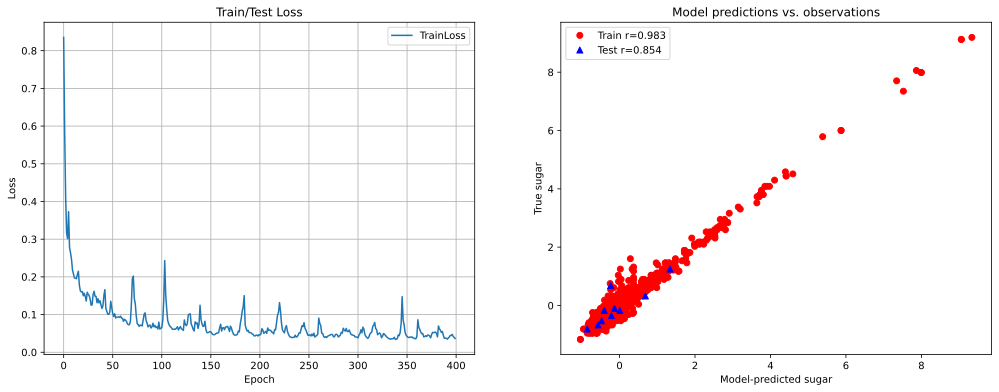

In [80]:
#plot some results
fig,ax=plt.subplots(1,2,figsize=(17,6))

ax[0].plot(trainLoss,label='TrainLoss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Train/Test Loss')
ax[0].legend()
ax[0].grid()


ax[1].plot(yHatTrain.detach(),train_labelT,'ro')
ax[1].plot(yHatTest.detach(),test_labelT,'b^')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predictions vs. observations')

#correlations between predictions and outputs
corrTrain=np.corrcoef(yHatTrain.detach().numpy().T,train_labelT.numpy().T)[1,0]
corrTest=np.corrcoef(yHatTest.detach().numpy().T,test_labelT.numpy().T)[1,0]
ax[1].legend([ f'Train r={corrTrain:.3f}',f'Test r={corrTest:.3f}' ])
plt.show()